## US Consumer Price Index (CPI) and Employment Statistics Analysis for Financial Activities Job categories

### Objective
This notebook has been design to replicate my work done in 2018 to analyze employment levels and inflations for each metro area to figure out how each compares in terms of economic affordability.

### Data source
US Bureau of Labor Statistics
* CPI-W
* State & Metro Employment

### Classifications
Time of interest (Target data are to be normalized against base line)
* Baseline: 2010
* Target: 2016

Geographic areas
* Primary: Areas from State & Metro data are used (e.g., Charlotte-Concord-Gastonia)
* Data interpolation: For metro-areas without having explicit data (e.g., Hourly Wages), state-wide or Census division (e.g., SouthEast)

Employment
* Industry: Only *financial activities* (Supersector code **55**) is selected
* Key figures: Average Hourly Wages, Employment

CPI (Selected categories are to be aggregated to form different scenarios)
* Components
    * Housing: Rent, Housing Operations
    * Food: Eat-in, Eat-out
    * Energy: Household
    * Medical Care
    * Recreation
    * Transportation

In [1]:
# Load libraries
library(dplyr)
library(readr)
library(ggplot2)
library(sf)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.7.2, GDAL 2.4.2, PROJ 5.2.0



In [257]:
# Read employment data
employments <- readr::read_tsv('data/Employment Statistics/sm.data.71.FinancialActivities.Current.txt')

employments <- employments %>%
    subset(select=-c(footnote_codes))

head(employments)

Parsed with column specification:
cols(
  series_id = col_character(),
  year = col_double(),
  period = col_character(),
  value = col_double(),
  footnote_codes = col_character()
)



series_id,year,period,value
<chr>,<dbl>,<chr>,<dbl>
SMS01000005500000001,2007,M01,100.1
SMS01000005500000001,2007,M02,99.9
SMS01000005500000001,2007,M03,100.1
SMS01000005500000001,2007,M04,99.5
SMS01000005500000001,2007,M05,99.7
SMS01000005500000001,2007,M06,99.8


In [258]:
# Read merge info
state <- read_tsv('data/Employment Statistics/sm.state.txt')
head(state)
area <- read_tsv('data/Employment Statistics/sm.area.txt')
head(area)
period <- read_tsv('data/Employment Statistics/sm.period.txt')
head(period)
industry <- read_tsv('data/Employment Statistics/sm.industry.txt') %>%
    dplyr::select(industry_code,industry_name)
head(industry)
data_type <- read_tsv('data/Employment Statistics/sm.data_type.txt')
head(data_type)
area_map <- read_tsv('data/area_map.txt')
head(area_map)

Parsed with column specification:
cols(
  state_code = col_character(),
  state_abbr = col_character(),
  state_name = col_character()
)



state_code,state_abbr,state_name
<chr>,<chr>,<chr>
00,AS,All States
01,AL,Alabama
02,AK,Alaska
04,AZ,Arizona
05,AR,Arkansas
06,CA,California


Parsed with column specification:
cols(
  area_code = col_character(),
  area_name = col_character()
)



area_code,area_name
<chr>,<chr>
00000,Statewide
10180,"Abilene, TX"
10380,"Aguadilla-Isabela, PR"
10420,"Akron, OH"
10500,"Albany, GA"
10540,"Albany, OR"


Parsed with column specification:
cols(
  period = col_character(),
  mm = col_character(),
  month = col_character()
)



period,mm,month
<chr>,<chr>,<chr>
M01,JAN,January
M02,FEB,February
M03,MAR,March
M04,APR,April
M05,MAY,May
M06,JUN,June


Parsed with column specification:
cols(
  industry_code = col_character(),
  industry_name = col_character()
)



industry_code,industry_name
<chr>,<chr>
00000000,Total Nonfarm
05000000,Total Private
06000000,Goods Producing
07000000,Service-Providing
08000000,Private Service Providing
10000000,Mining and Logging


Parsed with column specification:
cols(
  data_type_code = col_character(),
  data_type_text = col_character()
)



data_type_code,data_type_text
<chr>,<chr>
01,"All Employees, In Thousands"
02,Average Weekly Hours of All Employees
03,"Average Hourly Earnings of All Employees, In Dollars"
06,"Production or Nonsupervisory Employees, In Thousands"
07,Average Weekly Hours of Production Employees
08,"Average Hourly Earnings of Production Employees, In Dollars"


Parsed with column specification:
cols(
  SM_code = col_character(),
  CPI_code = col_character()
)



SM_code,CPI_code
<chr>,<chr>
00000,NA
10180,N300
10380,PR
10420,S200
10500,N300
10540,N400


In [259]:
# Tidy up employment data
employments <- tidyr::separate(employments,'series_id',c('category','seasonal','state','area','industry','type'),sep=c(2,3,5,10,18)) %>%
    dplyr::rename("employment"="value") %>%
    dplyr::filter(industry == '55000000' & type %in% c('01','03') & year >= 2010 & period == 'M13' & seasonal != 'S') %>%
    subset(select=-c(seasonal))

head(employments)

category,state,area,industry,type,year,period,employment
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
SM,01,00000,55000000,01,2010,M13,92.0
SM,01,00000,55000000,01,2011,M13,92.4
SM,01,00000,55000000,01,2012,M13,92.6
SM,01,00000,55000000,01,2013,M13,94.2
SM,01,00000,55000000,01,2014,M13,94.8
SM,01,00000,55000000,01,2015,M13,95.4


In [260]:
# Merge dataset
employments <- employments %>%
    dplyr::inner_join(state,by=c('state'='state_code')) %>%
    dplyr::inner_join(area,by=c('area'='area_code')) %>%
    dplyr::inner_join(industry,by=c('industry'='industry_code')) %>%
    dplyr::inner_join(data_type,by=c('type'='data_type_code')) %>%
#     dplyr::inner_join(period,by=c('period')) %>%
    subset(select=-c(state,state_name,industry,period)) %>%
    dplyr::mutate(#mm=stringr::str_to_title(mm),
                  data_type_text=stringr::str_to_title(data_type_text)
                 ) %>%
    dplyr::rename('state'='state_abbr',
                  'area_code'='area',
                  'industry'='industry_name',
                  'data_type'='data_type_text'
#                   ,'month'='mm'
                 )

head(employments)

category,area_code,type,year,employment,state,area_name,industry,data_type
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
SM,00000,01,2010,92.0,AL,Statewide,Financial Activities,"All Employees, In Thousands"
SM,00000,01,2011,92.4,AL,Statewide,Financial Activities,"All Employees, In Thousands"
SM,00000,01,2012,92.6,AL,Statewide,Financial Activities,"All Employees, In Thousands"
SM,00000,01,2013,94.2,AL,Statewide,Financial Activities,"All Employees, In Thousands"
SM,00000,01,2014,94.8,AL,Statewide,Financial Activities,"All Employees, In Thousands"
SM,00000,01,2015,95.4,AL,Statewide,Financial Activities,"All Employees, In Thousands"


In [241]:
# # Aggregate data by year
# employments <- employments %>%
#     dplyr::group_by(category,type,year,state,area,industry,data_type) %>%
#     dplyr::summarize(employment=mean(employment,na.rm=TRUE)) %>%
#     dplyr::ungroup() %>%
#     dplyr::group_by(category,year,state,area,industry) %>%
#     dplyr::mutate(n=dplyr::n()) %>%
#     dplyr::ungroup()

# head(employments)

In [261]:
state_cat <- list('AL'='N300','LA'='N300','AR'='N300','DE'='N300','DC'='N300','FL'='N300','GA'='N300','KY'='N300','LA'='N300','MD'='N300','MS'='N300','NC'='N300','OK'='N300','SC'='N300','TN'='N300','TX'='N300','VA'='N300','WV'='N300',
                 'AZ'='N400','CA'='N400','CO'='N400','ID'='N400','MT'='N400','NV'='N400','OR'='N400','UT'='N400','WA'='N400','WY'='N400','NM'='N400',
                 'CT'='N100','ME'='N100','MA'='N100','NH'='N100','NJ'='N100','NY'='N100','PA'='N100','RI'='N100','VT'='N100',
                 'IL'='N200','IN'='N200','IA'='N200','KS'='N200','MI'='N200','MN'='N200','MO'='N200','NE'='N200','ND'='N200','OH'='N200','SD'='N200','WI'='N200')

employments <- employments %>%
    dplyr::inner_join(area_map,by=c('area_code'='SM_code'),keep=TRUE) %>%
    dplyr::mutate(CPI_code=ifelse(is.na(CPI_code),state_cat[state],CPI_code)) %>%
    dplyr::mutate(CPI_code=as.character(CPI_code)) %>%
    subset(select=-c(area_code)) %>% 
    dplyr::rename('emp_area'='area_name')
head(employments)

category,type,year,employment,state,emp_area,industry,data_type,CPI_code
<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
SM,01,2010,92.0,AL,Statewide,Financial Activities,"All Employees, In Thousands",N300
SM,01,2011,92.4,AL,Statewide,Financial Activities,"All Employees, In Thousands",N300
SM,01,2012,92.6,AL,Statewide,Financial Activities,"All Employees, In Thousands",N300
SM,01,2013,94.2,AL,Statewide,Financial Activities,"All Employees, In Thousands",N300
SM,01,2014,94.8,AL,Statewide,Financial Activities,"All Employees, In Thousands",N300
SM,01,2015,95.4,AL,Statewide,Financial Activities,"All Employees, In Thousands",N300


In [262]:
num_emps <- employments %>%
    dplyr::filter(type == '01') %>%
    dplyr::rename('num_emp'='employment') %>%
    subset(select=-c(type,data_type))

employments <- employments %>%
    dplyr::filter(type == '03') %>%
    dplyr::rename('wage'='employment') %>%
    subset(select=-c(type,data_type))

employments <- num_emps %>%
    dplyr::left_join(employments,by=c('category','year','state','emp_area','CPI_code','industry')) %>%
    dplyr::group_by(category,year,state,industry) %>%
    dplyr::mutate(wage=dplyr::if_else(is.na(wage),0,wage),
                 wage=sum(wage)) %>%
    dplyr::ungroup()

head(employments)

category,year,num_emp,state,emp_area,industry,CPI_code,wage
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
SM,2010,92.0,AL,Statewide,Financial Activities,N300,20.77
SM,2011,92.4,AL,Statewide,Financial Activities,N300,20.97
SM,2012,92.6,AL,Statewide,Financial Activities,N300,21.12
SM,2013,94.2,AL,Statewide,Financial Activities,N300,21.38
SM,2014,94.8,AL,Statewide,Financial Activities,N300,21.80
SM,2015,95.4,AL,Statewide,Financial Activities,N300,22.80


In [308]:
# Read CPI data
inflations <- readr::read_tsv('data/CPI-W/cw.data.0.Current.txt')

inflations <- inflations %>%
    subset(select=-c(footnote_codes))

head(inflations)

Parsed with column specification:
cols(
  series_id = col_character(),
  year = col_double(),
  period = col_character(),
  value = col_double(),
  footnote_codes = col_logical()
)



series_id,year,period,value
<chr>,<dbl>,<chr>,<dbl>
CWSR0000SA0,1997,M01,156.6
CWSR0000SA0,1997,M02,156.9
CWSR0000SA0,1997,M03,156.9
CWSR0000SA0,1997,M04,157.0
CWSR0000SA0,1997,M05,157.0
CWSR0000SA0,1997,M06,157.3


In [309]:
# Read merge info
area <- read_tsv('data/CPI-W/cw.area.txt') %>%
    dplyr::select(area_code,area_name)
head(area)
period <- read_tsv('data/CPI-W/cw.period.txt')
head(period)
item <- read_tsv('data/CPI-W/cw.item.txt') %>%
    dplyr::select(item_code,item_name)
head(item)

Parsed with column specification:
cols(
  area_code = col_character(),
  area_name = col_character(),
  display_level = col_double(),
  selectable = col_logical(),
  sort_sequence = col_double()
)



area_code,area_name
<chr>,<chr>
0000,U.S. city average
0100,Northeast
0110,New England
0120,Middle Atlantic
0200,Midwest
0230,East North Central


Parsed with column specification:
cols(
  period = col_character(),
  period_abbr = col_character(),
  period_name = col_character()
)



period,period_abbr,period_name
<chr>,<chr>,<chr>
M01,JAN,January
M02,FEB,February
M03,MAR,March
M04,APR,April
M05,MAY,May
M06,JUN,June


Parsed with column specification:
cols(
  item_code = col_character(),
  item_name = col_character(),
  display_level = col_double(),
  selectable = col_logical(),
  sort_sequence = col_double()
)



item_code,item_name
<chr>,<chr>
AA0,All items - old base
AA0R,Purchasing power of the consumer dollar - old base
SA0,All items
SA0E,Energy
SA0L1,All items less food
SA0L1E,All items less food and energy


In [310]:
# Tidy up CPI data
inflations <- tidyr::separate(inflations,'series_id',c('category','seasonal','periodicity','area','item'),sep=c(2,3,4,8)) %>%
    dplyr::rename("inflation"="value") %>%
    dplyr::filter(item %in% c('SA0','SA0L1E','SA0R','SAF1','SAF11','SEFV','SAH','SAH21','SAH3','SAM','SAR','SAT','SETB') & year >= 2010 & period == 'M13' & seasonal != 'S' & periodicity == 'R') %>%
    subset(select=-c(seasonal,periodicity))

head(inflations)

category,area,item,year,period,inflation
<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
CW,0000,SA0,2010,M13,213.967
CW,0000,SA0,2011,M13,221.575
CW,0000,SA0,2012,M13,226.229
CW,0000,SA0,2013,M13,229.324
CW,0000,SA0,2014,M13,232.771
CW,0000,SA0,2015,M13,231.810


In [311]:
# Merge dataset
inflations <- inflations %>%
#     dplyr::inner_join(area,by=c('area'='area_code')) %>%
    dplyr::inner_join(item,by=c('item'='item_code')) %>%
#     dplyr::inner_join(period,by=c('period')) %>%
    subset(select=-c(period)) 
#     dplyr::mutate(period_abbr=stringr::str_to_title(period_abbr)) %>%
#     dplyr::rename('area_code'='area'
#                   ,'month'='period_abbr'
#                  )

head(inflations)

category,area,item,year,inflation,item_name
<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>
CW,0000,SA0,2010,213.967,All items
CW,0000,SA0,2011,221.575,All items
CW,0000,SA0,2012,226.229,All items
CW,0000,SA0,2013,229.324,All items
CW,0000,SA0,2014,232.771,All items
CW,0000,SA0,2015,231.810,All items


In [313]:
inflations <- inflations %>%
    subset(select=-c(item)) %>%
    tidyr::spread(item_name,inflation)

head(inflations)

category,area,year,All items,All items less food and energy,Food,Food at home,Food away from home,Household energy,Household furnishings and operations,Housing,Medical care,Motor fuel,Purchasing power of the consumer dollar,Recreation,Transportation
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CW,0000,2010,213.967,214.835,218.730,214.638,226.204,187.272,121.555,212.880,389.766,240.094,46.7,109.812,192.560
CW,0000,2011,221.575,218.461,227.125,225.181,231.504,191.522,121.109,215.810,402.187,303.848,45.1,109.898,213.296
CW,0000,2012,226.229,223.114,233.059,230.737,238.189,187.269,121.784,219.287,417.750,313.867,44.2,111.127,218.749
CW,0000,2013,229.324,226.997,236.193,232.835,243.129,191.831,120.784,223.993,428.326,305.116,43.6,111.696,218.328
CW,0000,2014,232.771,230.799,241.990,238.639,248.996,200.183,118.934,229.896,438.254,293.583,43.0,111.797,216.387
CW,0000,2015,231.810,234.827,246.462,241.502,256.181,193.272,117.837,234.499,449.602,213.963,43.2,111.845,197.785


In [647]:
merged <- employments %>%
    dplyr::filter(emp_area != 'Statewide') %>%
    dplyr::inner_join(inflations,by=c('year','CPI_code'='area')) %>%
    dplyr::inner_join(area,by=c('CPI_code'='area_code')) %>%
    dplyr::mutate(area=sub('-.*|,.*|/.*','',emp_area)) %>%
    subset(select=-c(category.x,category.y,CPI_code,emp_area,area_name))

head(merged)

year,num_emp,state,industry,wage,All items,All items less food and energy,Food,Food at home,Food away from home,Household energy,Household furnishings and operations,Housing,Medical care,Motor fuel,Purchasing power of the consumer dollar,Recreation,Transportation,area
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2010,1.3,AL,Financial Activities,20.77,133.462,124.432,138.575,136.060,142.043,147.947,95.767,132.600,160.462,234.595,NA,111.684,130.420,Anniston
2011,1.3,AL,Financial Activities,20.97,138.828,126.786,143.788,143.049,144.607,152.516,95.568,135.195,165.635,298.971,NA,112.271,146.149,Anniston
2012,1.3,AL,Financial Activities,21.12,141.686,129.411,148.003,147.419,148.599,152.310,96.691,137.660,170.686,304.646,NA,113.824,148.792,Anniston
2013,1.3,AL,Financial Activities,21.38,143.921,131.951,150.628,149.580,151.973,155.523,95.822,140.866,174.497,297.200,NA,115.105,148.770,Anniston
2014,1.4,AL,Financial Activities,21.80,146.067,134.197,154.324,152.961,156.204,162.621,93.293,144.694,177.915,285.559,NA,115.573,147.884,Anniston
2015,1.4,AL,Financial Activities,22.80,144.654,136.254,157.034,154.253,161.117,161.201,92.441,147.316,179.313,199.150,NA,115.197,133.742,Anniston


## Rank calculations
Overall employment rank is calculated with `number of employees` and `average hourly wages` (cardinal)

Basic idea: Difference in values between two adjacent areas (smallest difference) is divided by total difference for all areas (**Max - Min**)

Thus, areas which are closer to higher ranked ones have relatively higher ranks than ordianal ranking system. (When averaging two ranks, those regions can shine)

### Procedures of selections
After calculating ranks for `number of employees`, only regions having larger than mean value are kept. (appr. 70)

In [679]:
# Baseline summary
merged %>%
    dplyr::group_by(year) %>%
    dplyr::summarize(mean(num_emp),max(num_emp),mean(wage),max(wage)) %>%
    dplyr::ungroup()

`summarise()` ungrouping output (override with `.groups` argument)



year,mean(num_emp),max(num_emp),mean(wage),max(wage)
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010,89.184,733.9,28.7048,41.36
2011,89.284,742.1,28.8910,42.40
2012,91.202,741.2,29.5884,41.48
2013,92.606,740.2,30.3516,42.97
2014,94.260,748.3,30.8872,43.87
2015,96.580,757.7,32.1952,44.11
2016,99.604,765.9,33.1160,44.85
2017,101.688,773.6,33.9628,47.03
2018,112.776,781.4,35.8608,48.19


In [649]:
merged <- merged %>%
    dplyr::group_by(year) %>%
    dplyr::filter(num_emp >= mean(num_emp,na.rm=TRUE)) %>%
    dplyr::mutate(emp_order = length(num_emp)-(num_emp-min(num_emp))/((max(num_emp)-min(num_emp))/(length(num_emp)-1)),
                  wage_order = length(wage)-(wage-min(wage))/((max(wage)-min(wage))/(length(wage)-1)),
                  order = dense_rank(emp_order+wage_order)
    ) %>%
    arrange(order) %>%
    dplyr::ungroup() %>%
    dplyr::filter(order<=50) %>%
    subset(select=-c(emp_order,wage_order))

In [696]:
head(merged)

year,num_emp,state,industry,wage,All items,All items less food and energy,Food,Food at home,Food away from home,⋯,Household furnishings and operations,Housing,Medical care,Motor fuel,Purchasing power of the consumer dollar,Recreation,Transportation,area,order,wage_inc
<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>
2010,733.9,NY,Financial Activities,35.10,100.0000,100.0000,100.0000,100.0000,100.0000,⋯,100.00000,100.0000,100.0000,100.00000,NA,100.0000,100.0000,New York,1,100.00000
2011,742.1,NY,Financial Activities,34.89,103.2539,102.1480,103.4066,103.9189,102.6963,⋯,98.02342,101.3188,103.1700,128.16252,NA,102.1439,110.3024,New York,1,99.40171
2012,741.2,NY,Financial Activities,36.89,105.3673,104.3315,106.1411,106.7276,105.3513,⋯,98.00655,102.4669,108.4620,133.51231,NA,105.3779,113.8345,New York,1,105.09972
2013,740.2,NY,Financial Activities,39.43,107.0434,106.3969,107.2289,107.9289,106.2761,⋯,96.58672,104.7450,112.0840,129.33968,NA,106.3240,114.8591,New York,1,112.33618
2014,748.3,NY,Financial Activities,41.62,108.3790,107.9606,109.2152,109.8863,108.2102,⋯,93.92287,107.1171,115.2029,123.99711,NA,105.9807,113.8513,New York,1,118.57550
2015,757.7,NY,Financial Activities,43.15,108.0813,109.7481,111.3252,111.6563,110.9154,⋯,90.92338,108.0307,118.1707,87.58544,NA,106.0619,105.2692,New York,1,122.93447


In [660]:
# Calculate Wages and CPI increases (Percentage)
merged <- merged %>%
    dplyr::group_by(area) %>%
    dplyr::mutate(wage_inc = wage/first(wage)*100) %>%
    dplyr::mutate_at(vars(names(merged)[8:ncol(merged)-2]),funs(./first(.)*100)) %>%
    dplyr::ungroup()

In [697]:
# Plot of employment 
target_col <- c('num_emp','wage','wage_inc')
target_text <- c('# of workers(1K)','Avg Hourly wages ($)','Avg Hourly wages Chg (%)')
emp_maps <- list()


for (iter in 1:3) {
    # Set levels for descending chart        
    lvl <- merged %>%
        dplyr::filter(year==2019) %>%
        dplyr::arrange(!!sym(target_col[iter])) %>%
        dplyr::distinct(area)

    lvl <- as.vector(lvl$area)
    
    merged %>%
        dplyr::filter(year==2019) %>%
        dplyr::arrange(target_col[iter]) %>%
        dplyr::mutate(area=factor(area,levels=lvl))
    
    emp_maps[[iter]] <- merged %>%
        dplyr::filter(year==2019) %>%
        dplyr::arrange(target_col[iter]) %>%
        dplyr::mutate(area=factor(area,levels=lvl)) %>%
        ggplot2::ggplot(ggplot2::aes(y=area,x=!!sym(target_col[iter]))) +
        ggplot2::geom_col() +
        ggplot2::scale_x_continuous(expand=c(0,0))+
        ggplot2::labs(x=target_text[iter],y='Metro region') +
        ggplot2::labs(caption=paste("Source: US Bureau of Labor Statistics"))
#     emp_maps[[iter]]

}

# g <- do.call(gridExtra::arrangeGrob,emp_maps,c(ncol=1))

[[1]]


[[1]]


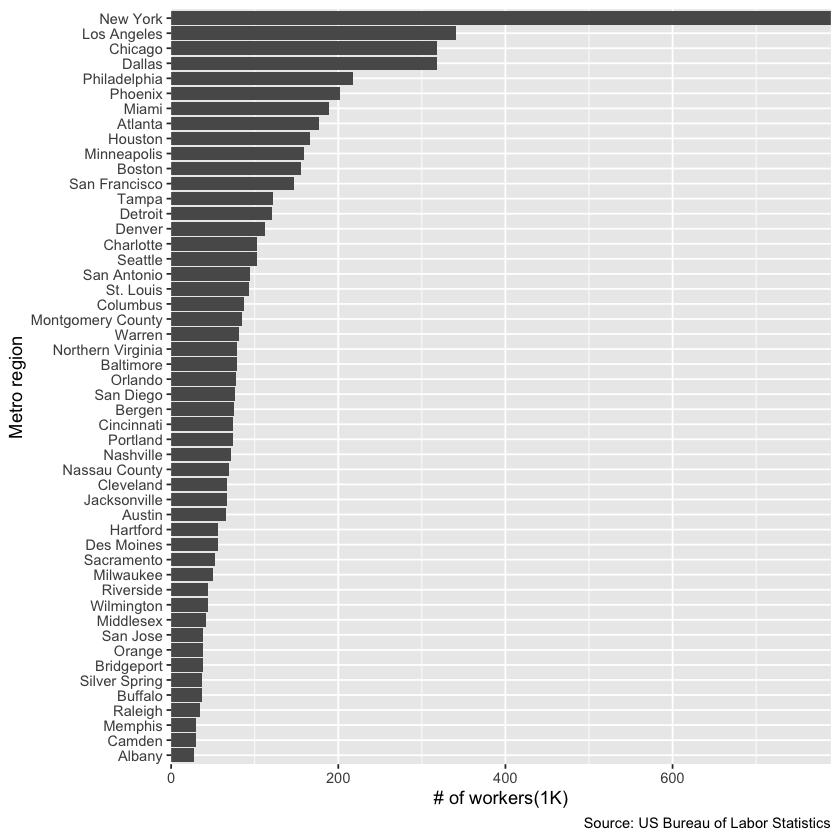

[[1]]


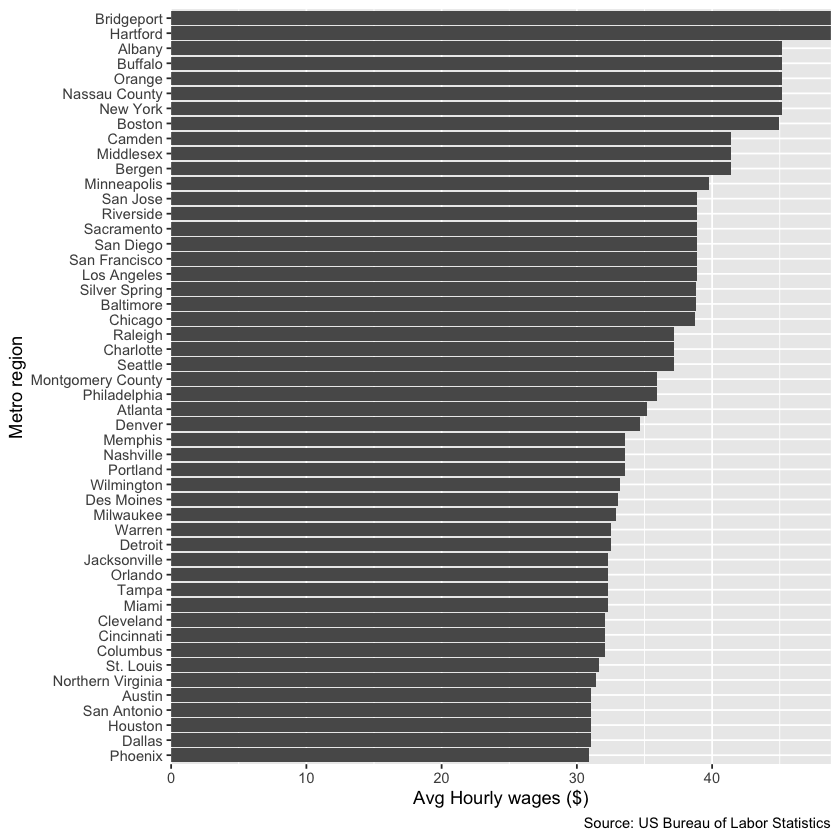

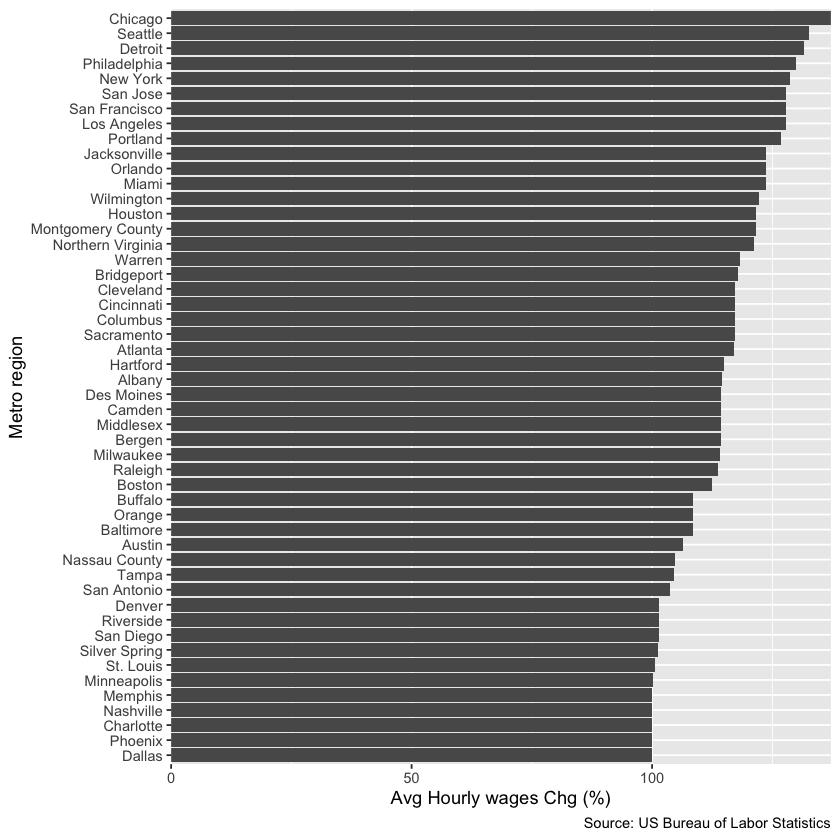

In [701]:
emp_maps[1][1]
emp_maps[2][1]
emp_maps[3][1]

Scenario	Housing	Food	Energy	Medical Care	Recreation	Transportation	Total
Rent	Housing Operation	Eat-in	Eat-out	Household	
Scenario 1	45%	10%	15%	5%	10%	0%	0%	15%	100%
Scenario 2	15%	10%	10%	10%	25%	0%	20%	10%	100%
Scenario 3	15%	10%	20%	10%	5%	30%	0%	10%	100%